In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import time 
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set default tensor type to float32
torch.set_default_tensor_type(torch.FloatTensor)

Using device: cuda


c:\Users\apisi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


# Normalizer

In [2]:
class Normalizer:
    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max
        
    def normalize(self, x):
        return 2.0 * (x - self.x_min) / (self.x_max - self.x_min) - 1.0
        
    def denormalize(self, x_norm):
        return 0.5 * (x_norm + 1.0) * (self.x_max - self.x_min) + self.x_min

# ANN

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.x_normalizer = Normalizer(x_min=0.0, x_max=10.0)
        self.y_normalizer = Normalizer(x_min=0.0, x_max=5.0) 
        
        # Network architecture
        self.hidden1 = nn.Linear(2, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 128)
        self.hidden4 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 2)
        
    def forward(self, xy):
        x_norm = self.x_normalizer.normalize(xy[:, 0:1])
        y_norm = self.y_normalizer.normalize(xy[:, 1:2])
        xy_norm = torch.cat([x_norm, y_norm], dim=1)
        
        h = torch.tanh(self.hidden1(xy_norm))
        h = torch.tanh(self.hidden2(h))
        h = torch.tanh(self.hidden3(h))
        h = torch.tanh(self.hidden4(h))
        output = self.output(h)
        
        u, v = output[:, 0:1], output[:, 1:2]
        
        return torch.cat([u, v], dim=1)

# Vertice

In [4]:
vertices = np.array([
    [0, 0],
    [0, 5],
    [5, 5],
    [8, 2],
    [10, 2],
    [10,0],
    [0,0]  # Closing the polygon
],dtype=np.float32)
path = Path(vertices)
def in_domain(x, y):
    points = np.column_stack((x.cpu().numpy(), y.cpu().numpy()))
    return torch.tensor(path.contains_points(points), dtype=torch.bool, device=device)

# Define boundary conditions
def BC_bottom(x, y):
    return ((y == 0) & (x >= 0) & (x <= 10)).squeeze()

def BC_left(x, y):
    return ((x == 0) & (y >= 0) & (y <= 5)).squeeze()

def BC_top(x, y):
    tol = 1e-6
    return (((y == 5) & (x >= 0) & (x <= 5)) | 
            (abs((y - 10) + x) < tol) & (x > 5) & (x < 8) |
            (y == 2) & (x >= 8) & (x <= 10)).squeeze()

def BC_right(x, y):
    return ((x == 10) & (y >= 0) & (y <= 2)).squeeze()

def BC_Slope(x, y):
    tol = 1e-6
    return (abs((y - 10) + x) < tol) & (x > 5) & (x < 8).squeeze()

# Huber loss

In [5]:
class HuberLoss:
    def __init__(self, delta=0.5):    #<------------------------ Delta Huber loss
        self.delta = delta
        
    def __call__(self, y_true, y_pred):
        error = torch.abs(y_true - y_pred)
        quadratic = torch.min(error, torch.tensor(self.delta))
        linear = error - quadratic
        return torch.mean(0.5 * quadratic ** 2 + self.delta * linear)

# BC Loss

In [6]:
def BC(xy, net):
    
    x, y = xy[:, 0].unsqueeze(1), xy[:, 1].unsqueeze(1)
    
    output = net(xy)
    u = output[:, 0:1]
    v = output[:, 1:2] 
    
    
    bc_b = ((y == 0) & (x >= 0) & (x <= 10)).squeeze() 
    bc_l = ((x == 0) & (y >= 0) & (y <= 5)).squeeze()
    bc_t = (((y == 5) & (x >= 0) & (x <= 5)) | 
            (abs((y - 10.0) + x) < 1e-6) & (x > 5) & (x < 8) |
            (y == 2) & (x >= 8) & (x <= 10)).squeeze()  
    bc_r = ((x == 10) & (y >= 0) & (y <= 2)).squeeze()  
    bc_slope = (abs((y - 10.0) + x) < 1e-6) & (x > 5) & (x < 8).squeeze()  
    
    huber = HuberLoss(delta=0.5)
    
    loss = huber(u[bc_b], torch.zeros_like(u[bc_b])) + huber(v[bc_b], torch.zeros_like(v[bc_b]))
    loss += huber(u[bc_l], torch.zeros_like(u[bc_l]))
    loss += huber(u[bc_r], torch.zeros_like(u[bc_r]))
    
    xy_top = xy[bc_t].requires_grad_(True)
    output_top = net(xy_top)
    u_top = output_top[:, 0:1]
    v_top = output_top[:, 1:2]
    
    u_x_top = torch.autograd.grad(u_top.sum(), xy_top, create_graph=True)[0][:, 0]
    u_y_top = torch.autograd.grad(u_top.sum(), xy_top, create_graph=True)[0][:, 1]
    v_x_top = torch.autograd.grad(v_top.sum(), xy_top, create_graph=True)[0][:, 0]
    v_y_top = torch.autograd.grad(v_top.sum(), xy_top, create_graph=True)[0][:, 1]
    
    nu = 0.3  
    E = 50.0  #Mpa
    
    sigma_xx_top = (E / ((1 + nu) * (1 - 2 * nu))) * (u_x_top + nu * v_y_top)
    sigma_yy_top = (E / ((1 + nu) * (1 - 2 * nu))) * (v_y_top + nu * u_x_top)
    sigma_xy_top = E / (2 * (1 + nu)) * (u_y_top + v_x_top)
    
    loss += huber(sigma_xy_top, torch.zeros_like(sigma_xy_top))
    loss += huber(sigma_xx_top, torch.zeros_like(sigma_xx_top))
    loss += huber(sigma_yy_top, torch.zeros_like(sigma_yy_top))
    
    return loss

# Adaptive sampling

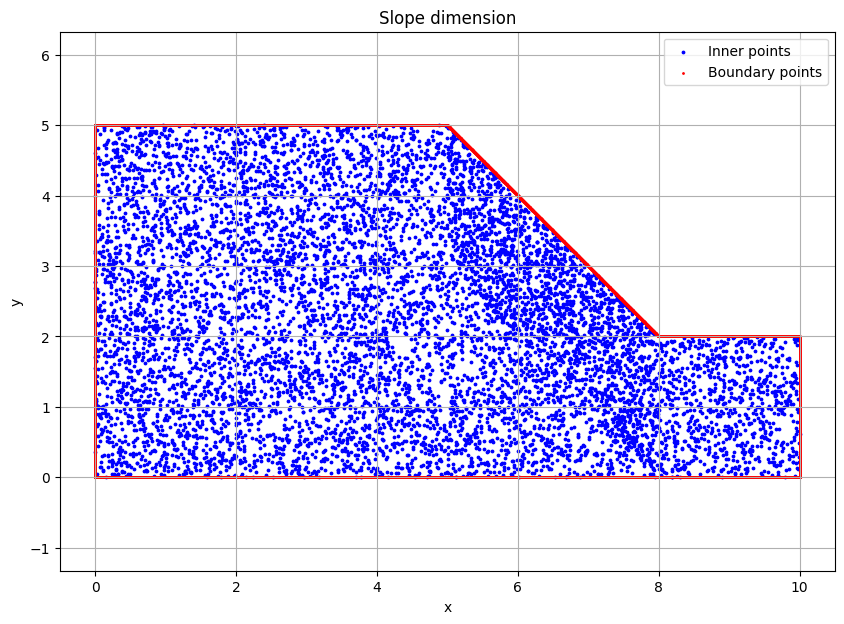


--- Number of point in Domain ---
(inner points): 8906
(boundary points): 15000
Total point: 23906
Area: 39.5 units
Density: 225.47 points/unit


In [7]:
def in_domain(x, y):
    mask_top_straight = (x >= 0) & (x <= 5) & (y <= 5)
    tol = 1e-6
    slope_line = (x > 5) & (x < 8) & (y <= (-x + 10.0 + tol))
    mask_top_right = (x >= 8) & (x <= 10.0) & (y <= 2)
    mask = (x >= 0) & (x <= 10.0) & (y >= 0) & (
        mask_top_straight | slope_line | mask_top_right
    )
    return mask

# function to generate random points
def generate_random_points(n_inner=10000, n_slope=2000, delta=2, n_boundary=5000):
    
    x_inner = torch.rand(n_inner, device=device) * 10.0  # x ระหว่าง 0 ถึง 10
    y_inner = torch.rand(n_inner, device=device) * 5.0   # y ระหว่าง 0 ถึง 5
    mask = in_domain(x_inner, y_inner)
    x_inner = x_inner[mask]
    y_inner = y_inner[mask]

    
    x_slope = 5.0 + torch.rand(n_slope, device=device) * 3.0  # x ระหว่าง 5 ถึง 8
    y_center = -x_slope + 10.0                                # y บนเส้น Slope
    y_slope = y_center + (torch.rand(n_slope, device=device) - 0.5) * 2 * delta  # y รอบเส้น Slope
    mask_slope = in_domain(x_slope, y_slope)
    x_slope = x_slope[mask_slope]
    y_slope = y_slope[mask_slope]

    #Total points
    x_all = torch.cat([x_inner, x_slope])
    y_all = torch.cat([y_inner, y_slope])

    
    t = torch.linspace(0, 1, n_boundary, device=device)
    segments = [
        ([0, 0, 0], [0, 5, 5]),
        ([0, 5, 8, 10, 10], [5, 5, 2, 2, 0]),
        ([10, 0], [0, 0])
    ]
    x_b, y_b = [], []
    for segment in segments:
        x_seg = torch.tensor(np.interp(t.cpu().numpy(), np.linspace(0, 1, len(segment[0])), segment[0]), dtype=torch.float32, device=device)
        y_seg = torch.tensor(np.interp(t.cpu().numpy(), np.linspace(0, 1, len(segment[1])), segment[1]), dtype=torch.float32, device=device)
        x_b.append(x_seg)
        y_b.append(y_seg)

    x_b = torch.cat(x_b).view(-1)
    y_b = torch.cat(y_b).view(-1)

    return x_all, y_all, x_b, y_b


x_inner, y_inner, x_b, y_b = generate_random_points(n_inner=10000, n_slope=2000, delta=2)

plt.figure(figsize=(10, 7))
plt.scatter(x_inner.cpu(), y_inner.cpu(), s=3,marker='o', color='blue', label='Inner points')
plt.scatter(x_b.cpu(), y_b.cpu(), s=1, color='red', label='Boundary points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Slope dimension')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


print("\n--- Number of point in Domain ---")
print(f"(inner points): {len(x_inner)}")
print(f"(boundary points): {len(x_b)}")
print(f"Total point: {len(x_inner) + len(x_b)}")


area_rectangle = 5 * 5  # พื้นที่สี่เหลี่ยมด้านซ้าย (0-5, 0-5)
area_trapezoid = (5 + 2) * 3 / 2  # พื้นที่สี่เหลี่ยมคางหมูกลาง (ความสูง=3, ด้านคู่ขนาน=5,2)
area_rectangle_right = 2 * 2  # พื้นที่สี่เหลี่ยมด้านขวา (8-10, 0-2)
total_area = area_rectangle + area_trapezoid + area_rectangle_right

print(f"Area: {total_area} units")
print(f"Density: {len(x_inner) / total_area:.2f} points/unit")

# PDE Loss

In [8]:
def PDE(x, y, net):
   
    xy = torch.cat([x, y], dim=1)
    xy.requires_grad = True
    
    output = net(xy)
    u = output[:, 0:1]
    v = output[:, 1:2]
    
    # Derivatives
    u_x = torch.autograd.grad(u.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1)  # ∂(u/u0)/∂(x/L0)
    u_y = torch.autograd.grad(u.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1)  # ∂(u/u0)/∂(y/L0)
    v_x = torch.autograd.grad(v.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1)  # ∂(v/u0)/∂(x/L0)
    v_y = torch.autograd.grad(v.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1)  # ∂(v/u0)/∂(y/L0)
    
    
    E = 50  # MN/m²
    nu = 0.3   
    gamma = 0.018 # MN/m³
    
    # Calculate stress components
    sigma_xx = E / (1 - nu**2) * (u_x + nu * v_y)
    sigma_yy = E / (1 - nu**2) * (v_y + nu * u_x)
    sigma_xy = E / (2 * (1 + nu)) * (u_y + v_x)
    
    # Body forces
    f_x = torch.zeros_like(x)
    f_y = -gamma * torch.ones_like(y)  # Gravity force
    
    huber = HuberLoss(delta=0.5)
    
    # Equilibrium equations
    R_x = torch.autograd.grad(sigma_xx.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1) + \
          torch.autograd.grad(sigma_xy.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1) + f_x
    R_y = torch.autograd.grad(sigma_xy.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1) + \
          torch.autograd.grad(sigma_yy.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1) + f_y
    
    # Loss function
    huber = HuberLoss(delta=0.5)
    loss_x = huber(R_x, torch.zeros_like(R_x))
    loss_y = huber(R_y, torch.zeros_like(R_y))
    
    return loss_x, loss_y

# Training


In [9]:
import pandas as pd

def train_pin(net, optimizer, n_epochs, grid_size=64, pretrain_bc_only=True, pretrain_epochs=10000):
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_path = 'best_model.pth'  # Path to save the best model
    
    history = {
        'pde_x': [],
        'pde_y': [],
        'bc': [],
        'total': [],
        'norm_pde_x': [],
        'norm_pde_y': [],
        'norm_bc': []
    }
    
    metrics = {
        'gpu_utils': [],
        'mem_utils': [],
        'epoch_times': [],
        'tflops': [],
        'losses': [],
        'training_time': [] 
    }
    
    window_size = 100
    moving_avg_time = 0

    # Loss weights
    w_pde_x = 1.0
    w_pde_y = 1.0
    w_bc = 1.0
    
    # Separate loss lists for plotting
    loss_adam = []  # For Adam optimizer
    loss_lbfgs = [] # For L-BFGS optimizer
    pde_loss_adam = []  # PDE Loss for Adam
    pde_loss_lbfgs = [] # PDE Loss for L-BFGS
    bc_loss_adam = []   # BC Loss for Adam
    bc_loss_lbfgs = []  # BC Loss for L-BFGS

    # ===== BC Pretraining Phase =====
    if pretrain_bc_only and pretrain_epochs > 0:
        print("\nPretraining BC Phase:")
        print("-" * 100)
        print(f"{'Epoch':>6} {'BC Loss':>12} {'LR':>10} {'Time(s)':>8} {'Avg Time':>10}")
        print("-" * 100)
        
        pretrain_start_time = time.time()  # Pretraining
        pretrain_moving_avg_time = 0
        
        for epoch in range(pretrain_epochs):
            start_time = time.time()
            optimizer.zero_grad()

            _, _, x_b, y_b = generate_random_points(n_inner=3000, n_slope=2000, delta=2, n_boundary=5000)
            xy_b = torch.stack([x_b, y_b], dim=1)
            bc_loss = BC(xy_b, net)
            bc_val = bc_loss.item()
            bc_loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2)

            def closure():
                optimizer.zero_grad()
                bc_loss = BC(xy_b, net)
                bc_loss.backward()
                return bc_loss
            
            optimizer.step(closure)

            end_time = time.time()
            epoch_time = end_time - start_time

            pretrain_moving_avg_time = 0.95 * pretrain_moving_avg_time + 0.05 * epoch_time if epoch > 0 else epoch_time

            if (epoch + 1) % 100 == 0:
                print(f"{epoch+1:6d} {bc_val:12.10f} {'N/A':>10} {epoch_time:8.2f} {pretrain_moving_avg_time:10.2f}")
        
        pretrain_end_time = time.time()  
        pretrain_duration = pretrain_end_time - pretrain_start_time 
        metrics['training_time'].append(pretrain_duration)

        print(f"\nPretraining completed. Total Pretraining Time: {pretrain_duration:.2f} seconds")

    # ===== Main Training Phase =====
    print("\nMain Training Statistics:")
    print("-" * 100)
    print(f"{'Epoch':>6} {'Loss':>12} {'Loss_pde_x':>10} {'Loss_pde_y':>10} {'Loss_bc':>10} {'TFLOPs/s':>10} {'Time(s)':>8} {'Avg Time':>10} {'Training Time':>12}")
    print("-" * 100)

    total_start_time = time.time()
    
    # Estimate FLOPs per forward-backward pass (rough estimate)
    n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    flops_per_sample = 2 * n_params  # forward + backward
    batch_size = 5000 + 2000 + 5000  # n_inner + n_slope + n_boundary
    total_flops_per_epoch = flops_per_sample * batch_size

    # Prepare data for CSV logging
    log_data = {
        'Epoch': [],
        'Total Loss': [],
        'PDE Loss': [],
        'BC Loss': [],
        'Optimizer': [],
        'Epoch Time (s)': [],
        'TFLOPs/s': [],
        'Training Time (s)': []
    }

    for epoch in range(n_epochs):
        start_time = time.time()
        optimizer.zero_grad()

        x_inner, y_inner, x_b, y_b = generate_random_points(n_inner=5000, n_slope=2000, delta=2, n_boundary=5000)
        xy = torch.stack([x_inner, y_inner], dim=1)

        output = net(xy)
        pde_loss_x, pde_loss_y = PDE(x_inner.unsqueeze(1), y_inner.unsqueeze(1), net)
        xy_b = torch.stack([x_b, y_b], dim=1)
        bc_loss = BC(xy_b, net)

        pde_x_val = pde_loss_x.item()
        pde_y_val = pde_loss_y.item()
        bc_val = bc_loss.item()

        total_loss = w_pde_x * pde_loss_x + w_pde_y * pde_loss_y + w_bc * bc_loss
        current_loss = total_loss.item()  # Get the current loss value

        # Check if this is the best model so far
        if current_loss < best_loss:
            best_loss = current_loss
            torch.save(net.state_dict(), best_model_path)  # Save the best model

        history['pde_x'].append(pde_x_val)
        history['pde_y'].append(pde_y_val)
        history['bc'].append(bc_val)
        history['total'].append(total_loss.item())

        total_raw = pde_x_val + pde_y_val + bc_val
        if total_raw > 0:
            history['norm_pde_x'].append(pde_x_val / total_raw)
            history['norm_pde_y'].append(pde_y_val / total_raw)
            history['norm_bc'].append(bc_val / total_raw)

        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2)

        def closure():
            optimizer.zero_grad()
            total_loss = w_pde_x * pde_loss_x + w_pde_y * pde_loss_y + w_bc * bc_loss
            total_loss.backward()
            return total_loss

        if epoch < 5000:
            optimizer.step()
            loss_adam.append(total_loss.item())  # Record Adam loss
            pde_loss_adam.append(pde_x_val + pde_y_val)  # Record PDE loss for Adam
            bc_loss_adam.append(bc_val)  # Record BC loss for Adam
            optimizer_type = "Adam"
        else:
            optimizer.step(closure)
            loss_lbfgs.append(total_loss.item()) # Record L-BFGS loss
            pde_loss_lbfgs.append(pde_x_val + pde_y_val) # Record PDE loss for L-BFGS
            bc_loss_lbfgs.append(bc_val) # Record BC loss for L-BFGS
            optimizer_type = "L-BFGS"

        end_time = time.time()
        epoch_time = end_time - start_time
        tflops = (total_flops_per_epoch / epoch_time) / 1e12

        metrics['epoch_times'].append(epoch_time)
        metrics['tflops'].append(tflops)
        metrics['losses'].append(total_loss.item())

        moving_avg_time = 0.95 * moving_avg_time + 0.05 * epoch_time if epoch > 0 else epoch_time

        # Track total training time
        total_elapsed_time = end_time - total_start_time
        metrics['training_time'].append(total_elapsed_time)

        # Log data for CSV
        log_data['Epoch'].append(epoch + 1)
        log_data['Total Loss'].append(total_loss.item())
        log_data['PDE Loss'].append(pde_x_val + pde_y_val)
        log_data['BC Loss'].append(bc_val)
        log_data['Optimizer'].append(optimizer_type)
        log_data['Epoch Time (s)'].append(epoch_time)
        log_data['TFLOPs/s'].append(tflops)
        log_data['Training Time (s)'].append(total_elapsed_time)

        if (epoch + 1) % 100 == 0:
            print(f"{epoch+1:6d} {total_loss.item():12.10f} {pde_x_val:10.10f} {pde_y_val:10.10f} "
                  f"{bc_val:10.10f} {tflops:10.4f} {epoch_time:8.2f} {moving_avg_time:10.2f} {total_elapsed_time:12.2f}")
    
    # Save log data to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv('training_log.csv', index=False)
    print("Training log saved to 'training_log.csv'.")

    # Plot the loss vs epoch graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(loss_adam)), loss_adam, label='Adam Optimizer', color='blue')
    plt.plot(range(len(loss_adam), len(loss_adam) + len(loss_lbfgs)), loss_lbfgs, label='L-BFGS Optimizer', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Total Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot PDE and BC Loss in the same graph
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(pde_loss_adam)), pde_loss_adam, label='Adam Optimizer (PDE)', color='green', linestyle='--')
    plt.plot(range(len(pde_loss_adam), len(pde_loss_adam) + len(pde_loss_lbfgs)), pde_loss_lbfgs, 
             label='L-BFGS Optimizer (PDE)', color='red', linestyle='--')
    plt.plot(range(len(bc_loss_adam)), bc_loss_adam, label='Adam Optimizer (BC)', color='purple', linestyle='-')
    plt.plot(range(len(bc_loss_adam), len(bc_loss_adam) + len(bc_loss_lbfgs)), bc_loss_lbfgs, 
             label='L-BFGS Optimizer (BC)', color='brown', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('PDE Loss and BC Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return net, metrics

# Post Processing

In [10]:
def plot_results(net, output_filename='PiNN3_data.csv'):
    
    nx, ny = 100, 100
    x = torch.linspace(0, 10.0, nx, device=device)
    y = torch.linspace(0, 5.0, ny, device=device)
    
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    
    X = xx.flatten()
    Y = yy.flatten()
    

    mask = in_domain(X, Y)
    mask_np = mask.cpu().numpy()
    
    
    XY = torch.stack([X, Y], dim=1)
    XY.requires_grad_(True)
    
    with torch.enable_grad():
        output = net(XY)
        U = output[:, 0:1] 
        V = output[:, 1:2]  
        
        U_x = torch.autograd.grad(U.sum(), XY, create_graph=True)[0][:, 0]
        U_y = torch.autograd.grad(U.sum(), XY, create_graph=True)[0][:, 1]
        V_x = torch.autograd.grad(V.sum(), XY, create_graph=True)[0][:, 0]
        V_y = torch.autograd.grad(V.sum(), XY, create_graph=True)[0][:, 1]
        

        E = 50  # Young's modulus
        nu = 0.3  # Poisson's ratio
        
        sigma_xx = E / (1 - nu**2) * (U_x + nu * V_y)
        sigma_yy = E / (1 - nu**2) * (V_y + nu * U_x)
        sigma_xy = E / (2 * (1 + nu)) * (U_y + V_x)
    

    
    X_real = X.detach().cpu().numpy()
    Y_real = Y.detach().cpu().numpy()
    U_real = U.detach().cpu().numpy().squeeze() 
    V_real = V.detach().cpu().numpy().squeeze()
    sigma_xx_real = sigma_xx.detach().cpu().numpy().squeeze()
    sigma_yy_real = sigma_yy.detach().cpu().numpy().squeeze()
    sigma_xy_real = sigma_xy.detach().cpu().numpy().squeeze()
    magnitude = np.sqrt(U_real**2 + V_real**2)
    
    # บันทึกผลลัพธ์
    df_out = pd.DataFrame({
        'X': X_real[mask_np],
        'Y': Y_real[mask_np],
        'ux': U_real[mask_np],
        'uy': V_real[mask_np],
        'sigma_xx': sigma_xx_real[mask_np]*1000,
        'sigma_yy': sigma_yy_real[mask_np]*1000,
        'sigma_xy': sigma_xy_real[mask_np]*1000,
        'magnitude': magnitude[mask_np]
    })

    df_out.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

# Main execution

In [11]:
# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize network and optimizer
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    # Train the network
    trained_net, metrics = train_pin(net=net, optimizer=optimizer, n_epochs=10000)
    # Plot results
    try:
        plot_results(trained_net)
    except Exception as e:
        print(f"Error in plot_results: {str(e)}")

Using device: cuda


KeyboardInterrupt: 